In [4]:
# bibliotecas de análise e manipulação
import pandas as pd 
import numpy as np
import matplotlib
import seaborn as sns
import yfinance as yf
import calendar
import requests
import datetime
import matplotlib.pyplot as plt
from matplotlib import ticker
from datetime import date
 
# visualização gráfica
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL # --> Gerar a decomposição dos dados
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# bibliotecas de previsão
from xgboost import XGBClassifier # --> Modelo de ML XGBoost
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# testes estatisticos
import ipywidgets as widgets
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


puxamos os dados do Ibovespa usando o yfinance.
explicar pq pegamos os dados de 1995 até o periodo atual.

In [10]:
dados_yf = []
dados_yf = yf.download('^BVSP', period="max", interval="1d", auto_adjust=True,  progress=False, multi_level_index=False)
dados_yf = pd.DataFrame(dados_yf.loc['2015-01-01':'2025-08-01'])

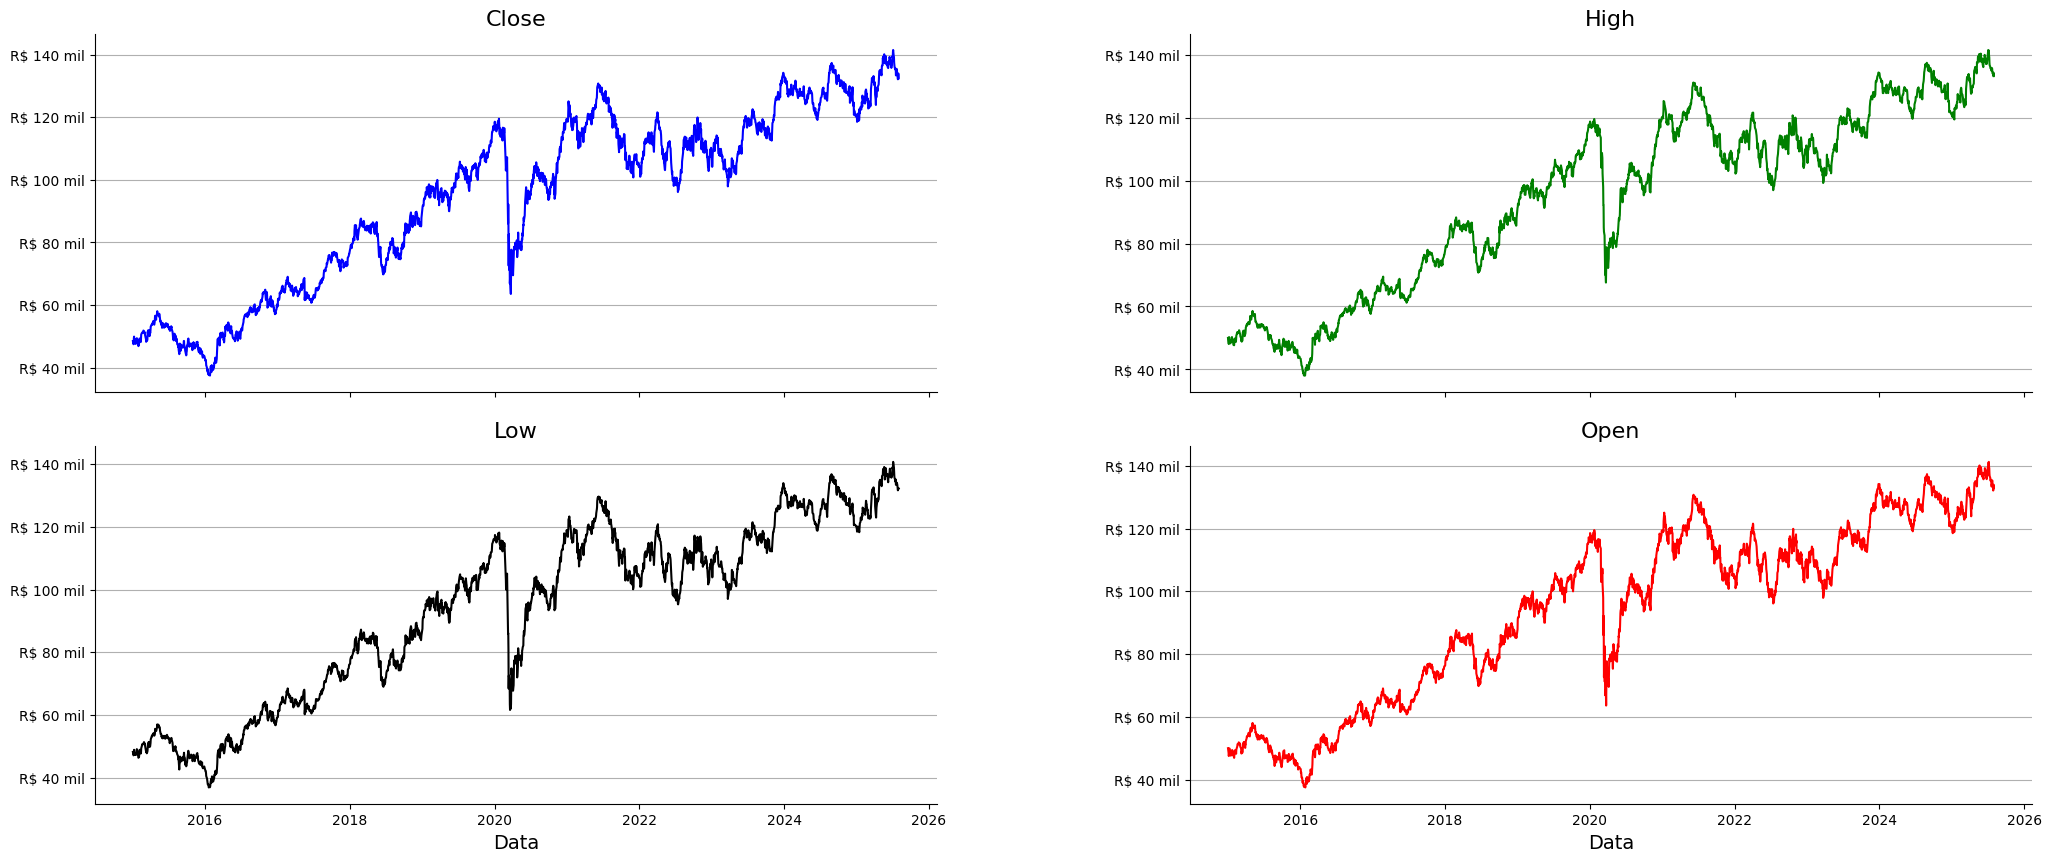

In [11]:
# visualização
def formatar_unidade(x, pos):
    return f'R$ {x/1000:.0f} mil'
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(25,10))
formatter = ticker.FuncFormatter(formatar_unidade)
# último
sns.lineplot(x=dados_yf.index,
            y=dados_yf['Close'],
             color='blue',
            ax=ax1)
# máxima
sns.lineplot(x=dados_yf.index,
            y=dados_yf['High'],
             color='green',
            ax=ax2)
# mínima
sns.lineplot(x=dados_yf.index,
            y=dados_yf['Low'],
             color='black',
            ax=ax3)
# abertura
sns.lineplot(x=dados_yf.index,
            y=dados_yf['Open'],
             color='red',
            ax=ax4)
sns.despine(right=True, top=True)
# Ajustar os títulos dos eixos e o espaçamento
plt.subplots_adjust(hspace=0.15, wspace=0.3)
for i in (ax1, ax2, ax3, ax4):
  i.grid(axis='y')

# Iterando as colunas nos títulos
for i, ax in zip(dados_yf.iloc[:, :4].columns, (ax1, ax2, ax3, ax4)):
    ax.set_title(i, fontsize=16)
# looping para setar o tamanho do x e tirar os y labels
for i in (ax1,ax2,ax3,ax4):
  i.set_xlabel('Data', fontsize=14)
  i.set_ylabel('')
  i.yaxis.set_major_formatter(formatter)
plt.show()

Explicar as séries temporais, junto da decomposiÇão realizada a seguir. pontos interessantes a falar: a série tem uma sazonalidade bem clara e aparente no ano de 2021, indicando quebra estrutural e necessidade de análise especializada neste período.

<Figure size 2000x1000 with 0 Axes>

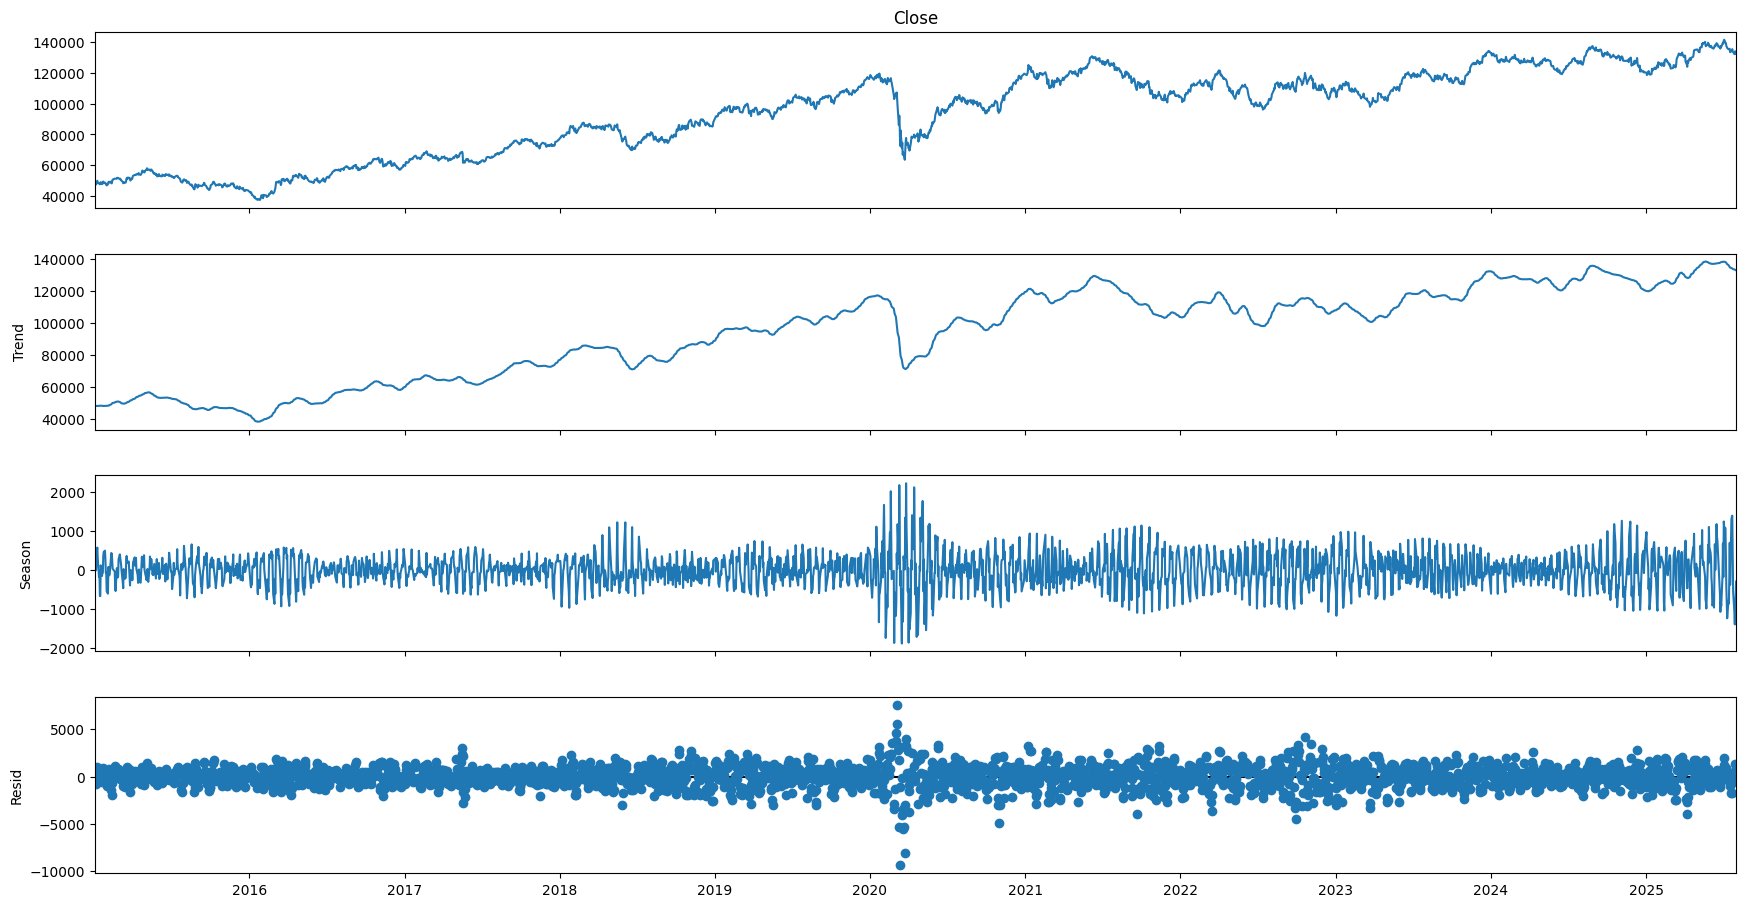

In [12]:
stl = STL(dados_yf['Close'], period=12, seasonal=13)
res = stl.fit()
fig = plt.figure(figsize=(20, 10))
res.plot().set_size_inches(20, 10)
plt.show()

In [81]:
df_sazonal = res.seasonal
df_sazonal.to_excel('i.xlsx')

Teste de Dickey-Fuller, ou teste de raiz unitária:

O teste é realizado para observar a presença de raiz unitária na série temporal, de forma a predizer o quão fortemente esta é afetada pela tendência.

Para interpretar o resultado do teste, precisamos inicialmente realizar um teste de hipótese com o p-valor para:

Aceitar (ou falhar em rejeitar) a Hipótese Nula (H0), sugerindo a presença de uma raiz unitária na série, e consequentemente sendo uma série não-estacionária;
Rejeitada a Hipótese Nula (H0), aceitamos a Hipótese Alternativa (H1) que sugere a não-presença de raiz unitária na série, indicando-a como série estacionária.
Para tal, observamos o p-valor e comparamos com o nível de significância esperado ao modelo. Desta forma:

Se o p-valor for maior que o nível de significância, aceitamos (ou falhamos em rejeitar) a hipótese nula (H0), e a série apresenta raiz unitária/é não-estacionária;
Se o p-valor for menor ou igual que o nível de significância, aceitamos a hipótese alternativa (H1), e a série não apresenta raiz unitária/é estacionária.

OU

p-valor > 0.05 -> série não-estacionária;
p-valor <= 0.05 -> série estacionária.

---

No teste de Dickey Fuller Aumentado, a hipótese nula é de que a série contém raiz unitária, e a alternativa é de que a série é estacionária.
se eu rejeito a nula (abaixo de 5%), a série é estacionária;
se eu falho em rejeitar (acima de 5%), a série tem raiz unitária.

No teste de KPSS, a hipótese nula é que a série é estacionária, e a alternativa de que a série tem raiz unitária.
se eu rejeito a nula, a série tem raiz unitária;
se eu falho em rejeitar a nula, a série é estacionária.

O teste de Phillips-Perron funciona similarmente ao teste de Dickey-Fuller, contudo sua análise difere ao não incluir as defasagens ao rodar a regressão. Nele:
se eu rejeito a nula, a série é estacionária;
se eu falho em rejeitar, a série tem raiz unitária.

Os valores apresentados por ambos os testes apontam que a série não é estacionária, uma vez que:
O teste de Dickey Fuller Aumentado apresenta p-valor acima de 1%, 5% e 10%, falhando em rejeitar a hipótese nula de que a série contém raiz unitária, determinando que a série não é estacionária;
O teste de KPSS apresenta p-valor abaixo de 1%, rejeitando a hipótese nula de que a série é estacionária;
O teste de Phillips-Perron apresentou p-valor acima de 5%, falhando em rejeitar a hipótese nula de que a série contém raiz unitária.

In [13]:
teste_adf = adfuller(dados_yf['Close'], regression = 'c')
print('Estatística ADF - Constante: %f' %teste_adf[0])
print('p-valor: %f' %teste_adf[1])
print('=-----------------------------------=')
teste_kpss = kpss(dados_yf['Close'])
print('Estatística KPSS: %f' %teste_kpss[0])
print('p-valor: %f' %teste_kpss[1])
print('=-----------------------------------=')
teste_pp = PhillipsPerron(dados_yf['Close'])
print(teste_pp.summary().as_text())

Estatística ADF - Constante: -1.433127
p-valor: 0.566296
=-----------------------------------=
Estatística KPSS: 7.659354
p-valor: 0.010000
=-----------------------------------=
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.423
P-value                         0.571
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\cayou\AppData\Local\Temp\ipykernel_11096\3622192582.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  teste_kpss = kpss(dados_yf['Close'])


explicar como a não-estacionaridade da série implica na análise. É visível observar tanto pelos testes anteriores quanto pela análise gráfica a do ACF da série de fechamento.

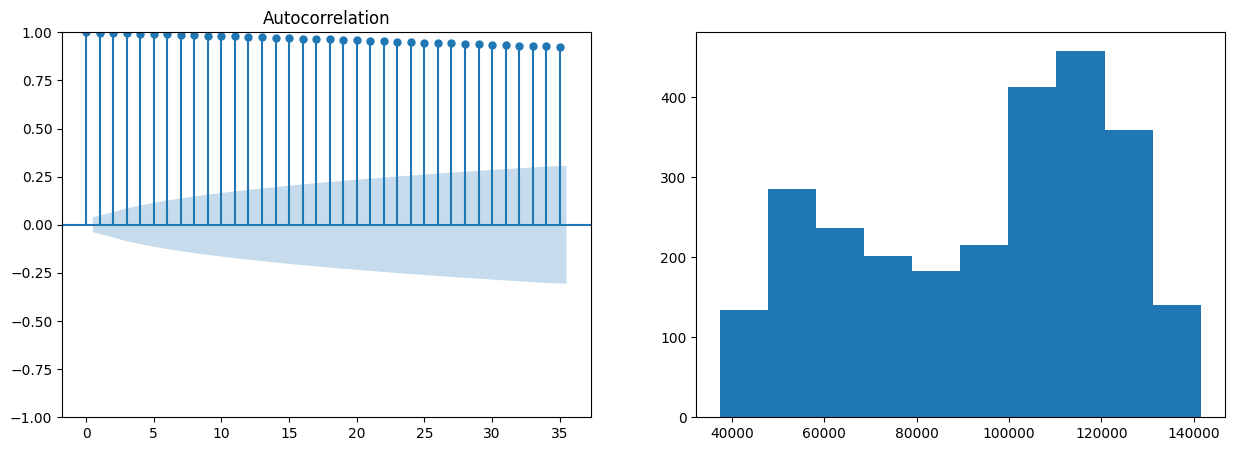

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plot_acf(dados_yf['Close'], ax = ax1)
plt.hist(dados_yf['Close'])
plt.show()

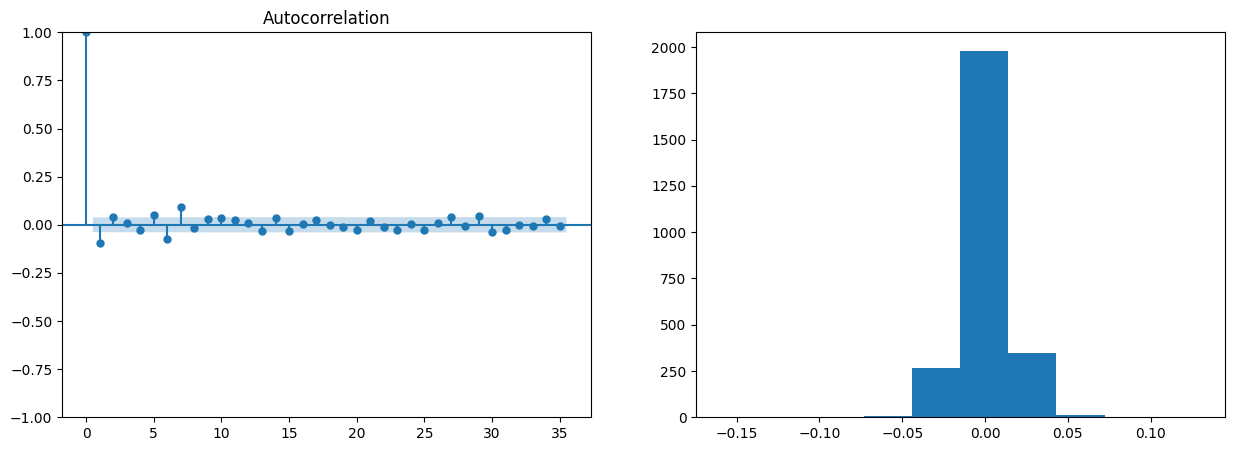

In [15]:
df_estacionaria = np.log(dados_yf['Close']).diff().dropna()

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plot_acf(df_estacionaria, ax = ax1)
plt.hist(df_estacionaria)
plt.show()

In [16]:
teste_adf = adfuller(df_estacionaria, regression = 'c')
print('Estatística ADF - Constante: %f' %teste_adf[0])
print('p-valor: %f' %teste_adf[1])
print('=-----------------------------------=')
teste_kpss = kpss(df_estacionaria)
print('Estatística KPSS: %f' %teste_kpss[0])
print('p-valor: %f' %teste_kpss[1])
print('=-----------------------------------=')
teste_pp = PhillipsPerron(df_estacionaria)
print(teste_pp.summary().as_text())

Estatística ADF - Constante: -18.381747
p-valor: 0.000000
=-----------------------------------=
Estatística KPSS: 0.058114
p-valor: 0.100000
=-----------------------------------=
     Phillips-Perron Test (Z-tau)    
Test Statistic                -56.143
P-value                         0.000
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\cayou\AppData\Local\Temp\ipykernel_11096\3744172140.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  teste_kpss = kpss(df_estacionaria)


## DELIMITAÇÃO DE PERÍODO DE TREINO E PERÍODO DE TESTE

In [29]:
df_treino = dados_yf['Close'].loc['2015-01-01':'2025-06-30']
df_teste = dados_yf['Close'].loc['2025-07-01':'2025-08-01']

df_treino_80 = dados_yf['Close'].loc['2015-01-01':'2023-06-27']
df_teste_80 = dados_yf['Close'].loc['2023-06-28':'2025-08-01']

In [28]:
dados_yf.iloc[2101]

Close       116681.0
High        117937.0
Low         116560.0
Open        117524.0
Volume    10646300.0
Name: 2023-06-28 00:00:00, dtype: float64

## PREVISÃO COM SARIMA


## PREVISÃO COM XGBOOST

## PREVISÃO COM HOLT-WINTERS

lembrete: vamos rodar primeiro com sp = 10, com base na inferencia que a sazonalidade se repete a cada ano. contudo, podemos tentar rodar com sp = n_de_meses caso seja interessante observar a reincidencia sazonal a cada mês.

Com base nos dados fornecidos, que representam o componente sazonal diário do Ibovespa após decomposição da série histórica, sugiro a utilização de um padrão sazonal semanal (5 dias úteis) como o componente mais adequado.

Justificativa:
Natureza dos dados financeiros:

O Ibovespa opera apenas em dias úteis (segunda a sexta-feira), excluindo finais de semana e feriados.

A sazonalidade mais relevante em séries financeiras diárias costuma ser de curto prazo, com padrões que se repetem a cada semana de negociação.

In [93]:
mod_wh_am = ExponentialSmoothing(df_treino, seasonal_periods=5, trend='add', seasonal='mul').fit(optimized=1)
mod_wh_aa = ExponentialSmoothing(df_treino, seasonal_periods=5, trend='add', seasonal='add').fit(optimized=1)
mod_wh_ma = ExponentialSmoothing(df_treino, seasonal_periods=5, trend='mul', seasonal='add').fit(optimized=1)
mod_wh_mm = ExponentialSmoothing(df_treino, seasonal_periods=5, trend='mul', seasonal='mul').fit(optimized=1)

pred_wh_am = mod_wh_am.forecast(24)
predval_wh_am = pd.concat([df_treino, pred_wh_am])
predval_wh_am = pd.DataFrame(predval_wh_am)
predval_wh_am = predval_wh_am.rename(columns={0: 'Previsto - HWam'})

pred_wh_aa = mod_wh_aa.forecast(24)
predval_wh_aa = pd.concat([df_treino, pred_wh_aa])
predval_wh_aa = pd.DataFrame(predval_wh_aa)
predval_wh_aa = predval_wh_aa.rename(columns={0: 'Previsto - HWaa'})

pred_wh_ma = mod_wh_ma.forecast(24)
predval_wh_ma = pd.concat([df_treino, pred_wh_ma])
predval_wh_ma = pd.DataFrame(predval_wh_ma)
predval_wh_ma = predval_wh_ma.rename(columns={0: 'Previsto - HWma'})

pred_wh_mm = mod_wh_mm.forecast(24)
predval_wh_mm = pd.concat([df_treino, pred_wh_mm])
predval_wh_mm = pd.DataFrame(predval_wh_mm)
predval_wh_mm = predval_wh_mm.rename(columns={0: 'Previsto - HWmm'})

df_prev = pd.DataFrame({
    'VALOR PREVISTO - AM': pred_wh_am,
    'VALOR PREVISTO - AA': pred_wh_aa,
    'VALOR PREVISTO - MA': pred_wh_ma,
    'VALOR PREVISTO - MM': pred_wh_mm
})
df_prev.index = df_teste.index

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequenc

In [94]:
print('MAPE - AM:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - AM'])*100,2),"%")
print('MSE - AM:', round(MSE(df_teste, df_prev['VALOR PREVISTO - AM']),2))
print(' ')
print('MAPE - MM:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - MM'])*100,2),"%")
print('MSE - MM:', round(MSE(df_teste, df_prev['VALOR PREVISTO - MM']),2))
print(' ')
print('MAPE - MA:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - MA'])*100,2),"%")
print('MSE - MA:', round(MSE(df_teste, df_prev['VALOR PREVISTO - MA']),2))
print(' ')
print('MAPE - AA:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - AA'])*100,2),"%")
print('MSE - AA:', round(MSE(df_teste, df_prev['VALOR PREVISTO - AA']),2))

MAPE - AM: 2.9 %
MSE - AM: 20097722.48
 
MAPE - MM: 2.73 %
MSE - MM: 17480590.96
 
MAPE - MA: 2.9 %
MSE - MA: 20092542.11
 
MAPE - AA: 2.92 %
MSE - AA: 20295758.38


In [ ]:
mod_wh_am = ExponentialSmoothing(df_treino_80, seasonal_periods=5, trend='add', seasonal='mul').fit(optimized=1)
mod_wh_aa = ExponentialSmoothing(df_treino_80, seasonal_periods=5, trend='add', seasonal='add').fit(optimized=1)
mod_wh_ma = ExponentialSmoothing(df_treino_80, seasonal_periods=5, trend='mul', seasonal='add').fit(optimized=1)
mod_wh_mm = ExponentialSmoothing(df_treino_80, seasonal_periods=5, trend='mul', seasonal='mul').fit(optimized=1)

pred_wh_am = mod_wh_am.forecast(524)
predval_wh_am = pd.concat([df_treino_80, pred_wh_am])
predval_wh_am = pd.DataFrame(predval_wh_am)
predval_wh_am = predval_wh_am.rename(columns={0: 'Previsto - HWam'})

pred_wh_aa = mod_wh_aa.forecast(524)
predval_wh_aa = pd.concat([df_treino_80, pred_wh_aa])
predval_wh_aa = pd.DataFrame(predval_wh_aa)
predval_wh_aa = predval_wh_aa.rename(columns={0: 'Previsto - HWaa'})

pred_wh_ma = mod_wh_ma.forecast(524)
predval_wh_ma = pd.concat([df_treino_80, pred_wh_ma])
predval_wh_ma = pd.DataFrame(predval_wh_ma)
predval_wh_ma = predval_wh_ma.rename(columns={0: 'Previsto - HWma'})

pred_wh_mm = mod_wh_mm.forecast(524)
predval_wh_mm = pd.concat([df_treino_80, pred_wh_mm])
predval_wh_mm = pd.DataFrame(predval_wh_mm)
predval_wh_mm = predval_wh_mm.rename(columns={0: 'Previsto - HWmm'})

df_prev_80 = pd.DataFrame({
    'VALOR PREVISTO - AM': pred_wh_am,
    'VALOR PREVISTO - AA': pred_wh_aa,
    'VALOR PREVISTO - MA': pred_wh_ma,
    'VALOR PREVISTO - MM': pred_wh_mm
})
df_prev_80.index = df_teste_80.index

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\

In [90]:
print('MAPE - AM:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - AM'])*100,2),"%")
print('MSE - AM:', round(MSE(df_teste_80, df_prev_80['VALOR PREVISTO - AM']),2))
print(' ')
print('MAPE - MM:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - MM'])*100,2),"%")
print('MSE - MM:', round(MSE(df_teste_80, df_prev_80['VALOR PREVISTO - MM']),2))
print(' ')
print('MAPE - MA:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - MA'])*100,2),"%")
print('MSE - MA:', round(MSE(df_teste_80, df_prev_80['VALOR PREVISTO - MA']),2))
print(' ')
print('MAPE - AA:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - AA'])*100,2),"%")
print('MSE - AA:', round(MSE(df_teste_80, df_prev_80['VALOR PREVISTO - AA']),2))

MAPE - AM: 3.75 %
MSE - AM: 32911942.02
 
MAPE - MM: 3.32 %
MSE - MM: 25886568.19
 
MAPE - MA: 4.49 %
MSE - MA: 48824157.56
 
MAPE - AA: 3.22 %
MSE - AA: 25595948.41


<Axes: title={'center': 'Previsão com treino 80:20'}, xlabel=' ', ylabel=' '>

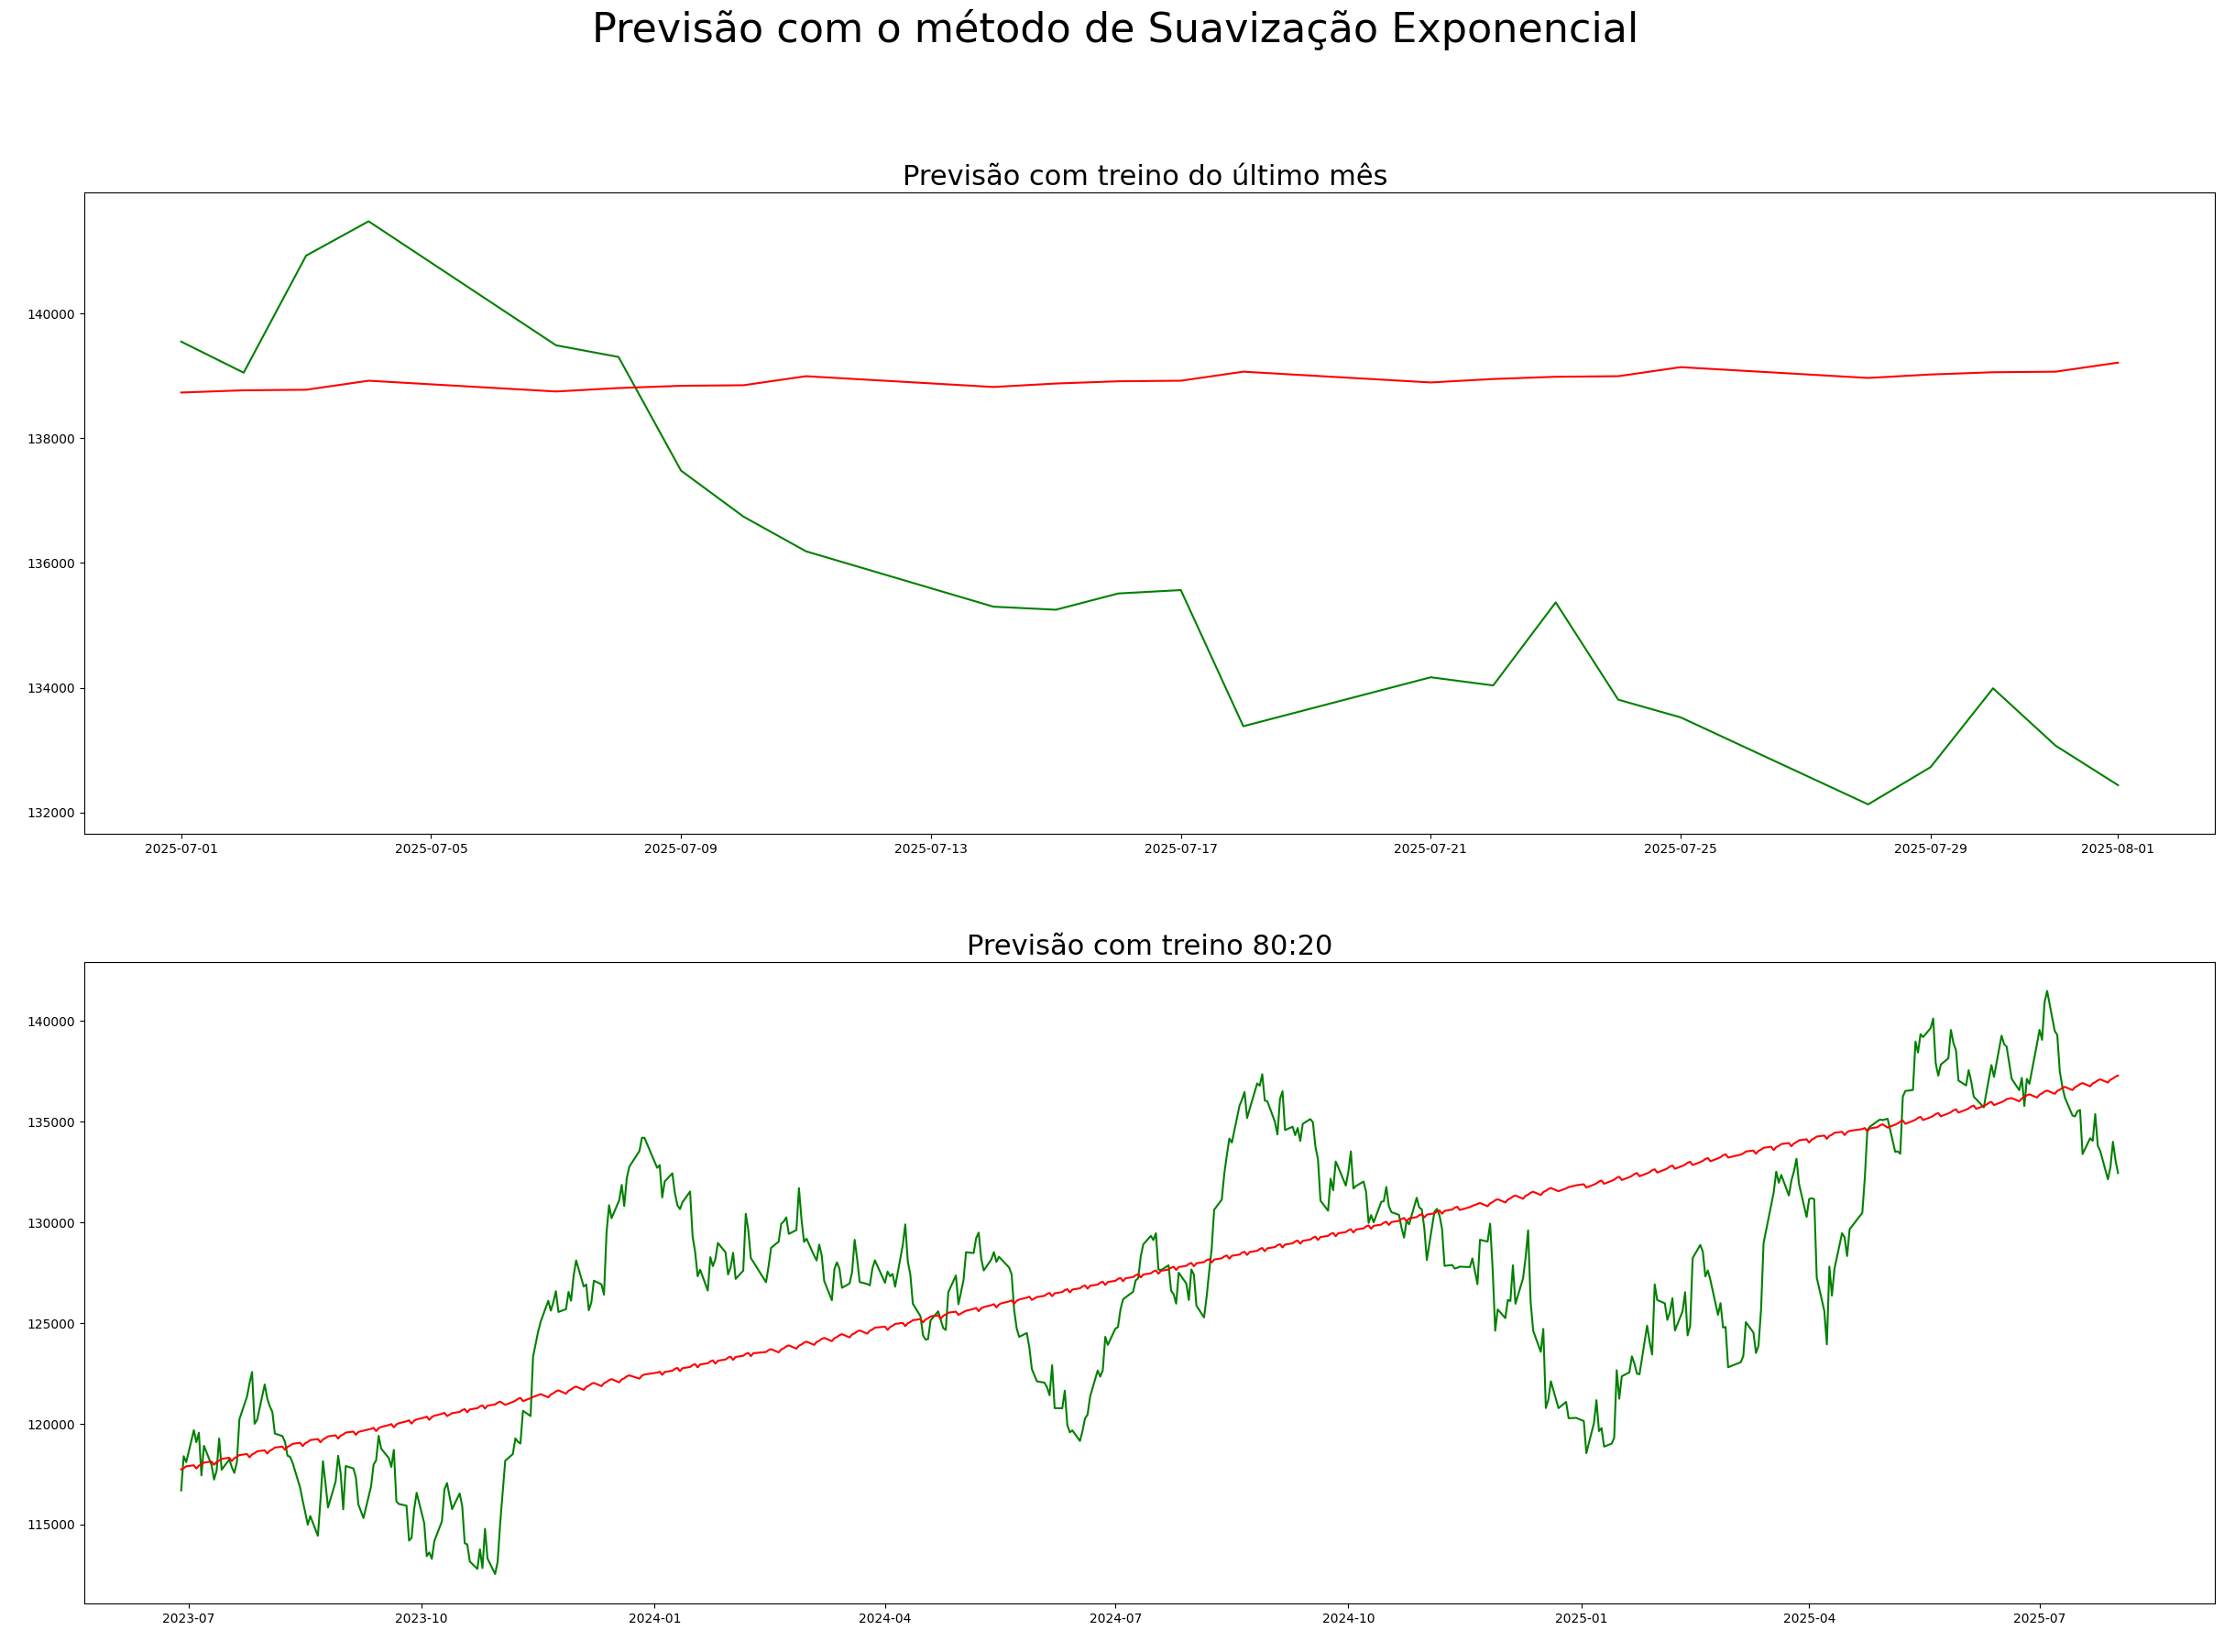

In [95]:
fig, ((ax0, ax1)) = plt.subplots(ncols=1, nrows=2 ,figsize = (30 , 20))
fig.suptitle('Previsão com o método de Suavização Exponencial', size = 32)
ax0.set_title('Previsão com treino do último mês ', size = 22)
ax0.set_xlabel(' ')
ax0.set_ylabel(' ')
ax1.set_title('Previsão com treino 80:20', size = 22)
ax1.set_xlabel(' ')
ax1.set_ylabel(' ')

sns.lineplot(x = df_teste.index,
             y = df_teste,
             color = 'green',
             ax=ax0)
sns.lineplot(x = df_prev.index,
             y = df_prev['VALOR PREVISTO - MM'],
             color = 'red',
             ax=ax0)

sns.lineplot(x = df_teste_80.index,
             y = df_teste_80,
             color = 'green',
             ax=ax1)
sns.lineplot(x = df_prev_80.index,
             y = df_prev_80['VALOR PREVISTO - AA'],
             color = 'red',
             ax=ax1)